# Prepare

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-196de940-1707-f032-286f-cc31bf030859)


## Install

In [2]:
!pip install rdkit
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 31.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.3 MB/s eta 0:00:00


## Import

In [3]:
!git clone https://github.com/Sawahiko/SMILE_to_Feature

Cloning into 'SMILE_to_Feature'...
remote: Enumerating objects: 2182, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 2182 (delta 7), reused 23 (delta 7), pack-reused 2159
Receiving objects: 100% (2182/2182), 633.63 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (884/884), done.
Updating files: 100% (838/838), done.


In [4]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import random

# Machine Learning
## Algorithm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
## Tool, Error Metric
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from joblib import dump, load

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader
#import pytorch_lightning as L

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

#Deep Learning Add
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

## Deep Learning

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # ตรวจสอบว่ามี GPU พร้อมกับ CUDA หรือไม่
class FCN(nn.Module):

    def __init__(self, N_Input, N_Output, N_Hidden, N_Layer, dropout_rate=0.2):
      super().__init__()
      activation = nn.ReLU
      self.fcs = nn.Sequential(*[
          nn.Linear(N_Input, N_Hidden),
          activation()])
      self.fch = nn.Sequential(*[
                  nn.Sequential(*[
                    nn.Linear(N_Hidden, N_Hidden),
                    nn.Dropout(p=dropout_rate),
                    activation()]) for _ in range(N_Layer-1)])
      self.fce = nn.Linear(N_Hidden, N_Output)

      self.double()

    def forward(self, input):
      x = self.fcs(input)
      x = self.fch(x)
      x = self.fce(x)
      return x

def DL(x_train, y_train):
    temp_tensor = x_train[x_train.shape[1]-1].reset_index(drop=True)

    x_train = x_train.drop(columns=x_train.shape[1]-1)
    inputs = torch.tensor(x_train.values)
    labels = torch.tensor(y_train.values)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset)

    model = FCN(x_train.shape[1], 1, 200, 3)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(50):
      total_loss = 0

      for iteration in range(len(inputs)):
        #print(iteration)
        input_i = inputs[iteration]

        temp_i = torch.tensor(temp_tensor[iteration])
        label_i = labels[iteration]

        #print(label_i)
        output_i = model(input_i)
        loss = sum((output_i - label_i)**2)

        #Psat_pre = Psat_cal(temp_i, output_i[0], output_i[1], output_i[2])
        #Psat_an = Psat_cal(temp_i, label_i[0], label_i[1], label_i[2])
        #loss2 = (Psat_an - Psat_pre)**2

        loss_all = loss
        #print(f"loss1 : {loss}  loss2: {loss2}")
        loss_all.backward()

        total_loss += float(loss)

      optimizer.step()
      optimizer.zero_grad()

      if(epoch%5 == 0):
        print(f"Step: {epoch} , output : {output_i.detach().numpy()},  loss : {loss_all}")

    return model
def DL2(x_train, y_train):

    temp_tensor = x_train[x_train.shape[1]-1].reset_index(drop=True)

    x_train = x_train.drop(columns=x_train.shape[1]-1)
    inputs = torch.tensor(x_train.values).to(device)
    labels = torch.tensor(y_train.values).to(device)

    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset)

    model = FCN(x_train.shape[1], 1, 1000, 4).to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(50):
      total_loss = 0

      for iteration in range(len(inputs)):
        #print(iteration)
        input_i = inputs[iteration]

        temp_i = torch.tensor(temp_tensor[iteration])
        label_i = labels[iteration]

        #print(label_i)
        output_i = model(input_i)
        loss = sum((output_i - label_i)**2)

        #Psat_pre = output_i
        #Psat_an = Psat_cal(temp_i, label_i[0], label_i[1], label_i[2])
        #loss2 = (Psat_an - Psat_pre)**2

        loss_all = loss
        #loss_all = loss + 10**(loss2) *10
        #print(f"loss1 : {loss}  loss2: {loss2}")
        loss_all.backward()

        total_loss += float(loss)

      optimizer.step()
      optimizer.zero_grad()

      if(epoch%5 == 0):
        print(f"Step: {epoch} , output : {(output_i.detach().cpu().numpy())},  loss : {loss_all}")

    return model

# Run Training

## Before

In [6]:
#%% Import Data
df = pd.read_csv("/content/SMILE_to_Feature/Second Semester/[Use] Main File/Psat_NO_ABCTminTmaxC1-12.csv")
df = df[df['SMILES'] != "None"]
df = df.drop_duplicates(subset='SMILES').reset_index(drop=True)
df.sort_values(by="No.C")
#len(df["SMILES"].unique())

,Unnamed: 0,Column1,Name,SMILES,A,B,C,Tmin,Tmax,No.C,Atom,Count Unique Atom,Pass Screen,Atom2
0,0,0,Methanal,C=O,21.370292,2204.126554,-30.150,190,271,1,"[1, 6, 8]",3,True,CHO
33,58,75,Formamide,C(=O)N,23.311763,5274.025104,-44.106,391,466,1,"[1, 6, 7, 8]",4,True,CHON
1226,2239,2630,Methyl hydroperoxide,COO,24.159183,4521.153461,-0.696,243,323,1,"[1, 6, 8]",3,True,CHO
760,1340,1560,Methyl nitrate,CO[N+](=O)[O-],22.885554,3653.755841,-15.925,263,333,1,"[1, 6, 7, 8]",4,True,CHON
504,768,888,Carbon dioxide,C(=O)=O,21.787336,1722.978373,-16.900,216,273,1,"[6, 8]",2,True,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,853,997,Biphenylene,C1=CC=C2C(=C1)C3=CC=CC=C23,22.477513,5342.621416,-51.020,338,408,12,"[1, 6]",2,True,CH
202,344,411,Tributylamine,CCCCN(CCCC)CCCC,20.560312,3547.811598,-93.996,336,488,12,"[1, 6, 7]",3,True,CHN
1966,3546,4298,"3-Ethyl-2,6-dimethyloctane",CCC(C)CCC(CC)C(C)C,20.142945,3291.637494,-88.150,470,470,12,"[1, 6]",2,True,CH
1997,3577,4329,"3,4-Diethyl-2,4-dimethylhexane",CCC(C(C)C)C(C)(CC)CC,19.919272,3214.592997,-90.150,473,473,12,"[1, 6]",2,True,CH


## Split

In [7]:
# New Train-Test Split
random.seed(42)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [8]:
# Genearate Temp in Tmin-Tmax and expand
df1 = train.copy()
    ## Function to generate equally distributed points
def generate_points(row, amount_point):
    start = row["Tmin"]; end = row["Tmax"];
    return np.linspace(start, end, amount_point)
df1["T"] = df1.apply(lambda x : generate_points(x, 5), axis=1)

df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
df1 = df1.reset_index(drop=True)

# Generate VP from Antione Coeff and Temp
def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))

df1["Vapor_Presssure"] = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])
#test = df1[df1["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])]
#print(test[['SMILES','Vapor_Presssure']].sort_values(by="Vapor_Presssure").head(5))
#print(f"\n {test[['SMILES','Vapor_Presssure']].index} ")
# Get Needed Table and split for Training
df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
df2 = df2[~df2["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])].reset_index()
#print(df2[['SMILES','Vapor_Presssure']].sort_values(by="Vapor_Presssure").head(5))
X_data= df2[["SMILES"]]               # feature: SMILE, T
Y_data= df2[["Vapor_Presssure"]]        # Target : Psat
print(df2.sort_values(by="Vapor_Presssure"))

      index                          SMILES      T  Vapor_Presssure
4155   4155                  C(CO)N(CCO)N=O  273.0        -5.527856
3895   3895                     CC(C)(C)N=O  288.0        -5.178898
3896   3896                     CC(C)(C)N=O  293.0        -4.636487
3475   3475  C(CO[N+](=O)[O-])O[N+](=O)[O-]  240.0        -4.204737
3897   3897                     CC(C)(C)N=O  298.0        -4.112278
...     ...                             ...    ...              ...
4055   4055                      C1CCC(C1)N  318.0        18.435562
4056   4056                      C1CCC(C1)N  343.0        18.646947
4057   4057                      C1CCC(C1)N  368.0        18.822911
4058   4058                      C1CCC(C1)N  393.0        18.971667
4059   4059                      C1CCC(C1)N  418.0        19.099075

[8420 rows x 4 columns]


In [9]:
# %% Fingerprint
# Parameter for Generate Morgan Fingerprint
MF_radius = 3;   MF_bit = 2048

# Generate Fingerprint from SMILE
X_data_use = X_data.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))    # Create Mol object from SMILES
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))         # Create Morgan Fingerprint from Mol object


# Transfrom Fingerprint to Datafrme that we can use for training
X_data_use["arr_count_morgan_fp"] = 0
X_data_fp = []
for i in range(X_data_use.shape[0]):
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)

# Final Data for Training
x_data_fp[MF_bit] = df2["T"]      # Input  = Fingerprint + Temp
y_data_fp = Y_data.copy()         # Output = Vapor Pressure

x_train_notz = x_data_fp.copy()
y_train_notz = np.ravel(y_data_fp.copy())

In [10]:
# Genearate Temp in Tmin-Tmax and expand
df1 = test.copy()
    ## Function to generate equally distributed points
def generate_points(row, amount_point):
    start = row["Tmin"]; end = row["Tmax"];
    return np.linspace(start, end, amount_point)
df1["T"] = df1.apply(lambda x : generate_points(x, 5), axis=1)

df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
df1 = df1.reset_index(drop=True)
#print(test)
# Generate VP from Antione Coeff and Temp
def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))

df1["Vapor_Presssure"] = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])

# Get Needed Table and split for Training
df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
df2 = df2[~df2["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])].reset_index()
X_data= df2[["SMILES"]]               # feature: SMILE, T
Y_data= df2[["Vapor_Presssure"]]        # Target : Psat
#df[df["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])]
print(df2.sort_values(by="Vapor_Presssure"))

      index                                             SMILES       T  \
1765   1765                                    CCCCCCC1COCCC1O  293.00   
600     600                                        C(CC#N)CC#N  277.00   
380     380                                       CCCCCCCCCCCO  293.00   
601     601                                        C(CC#N)CC#N  283.75   
1335   1335  CCOC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+]...  351.00   
...     ...                                                ...     ...   
488     488                                            C(=O)=O  258.75   
609     609                                       CC(C)C(=O)OC  533.00   
468     468                                           C1COCCO1  544.00   
489     489                                            C(=O)=O  273.00   
469     469                                           C1COCCO1  583.00   

      Vapor_Presssure  
1765        -2.641542  
600         -1.972574  
380         -1.488379  
601         -1.

In [11]:
df2

,index,SMILES,T,Vapor_Presssure
0,0,C=O,190.00,7.581574
1,1,C=O,210.25,9.131944
2,2,C=O,230.50,10.368912
3,3,C=O,250.75,11.378785
4,4,C=O,271.00,12.218843
...,...,...,...,...
2130,2130,C/C=C(/CC1=CC=CC=C1)\C=O,333.00,2.832162
2131,2131,C/C=C(/CC1=CC=CC=C1)\C=O,343.25,3.697618
2132,2132,C/C=C(/CC1=CC=CC=C1)\C=O,353.50,4.466759
2133,2133,C/C=C(/CC1=CC=CC=C1)\C=O,363.75,5.154813


In [12]:
# %% Fingerprint
# Parameter for Generate Morgan Fingerprint
MF_radius = 3;   MF_bit = 2048

# Generate Fingerprint from SMILE
X_data_use = X_data.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))    # Create Mol object from SMILES
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))         # Create Morgan Fingerprint from Mol object


# Transfrom Fingerprint to Datafrme that we can use for training
X_data_use["arr_count_morgan_fp"] = 0
X_data_fp = []
for i in range(X_data_use.shape[0]):
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)

# Final Data for Training
x_data_fp[MF_bit] = df2["T"]      # Input  = Fingerprint + Temp
y_data_fp = Y_data.copy()         # Output = Vapor Pressure

x_test_notz = x_data_fp.copy()
y_test_notz = np.ravel(y_data_fp.copy())

In [13]:
x_train_notz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8420 entries, 0 to 8419
Columns: 2049 entries, 0 to 2048
dtypes: float32(2049)
memory usage: 65.8 MB


In [14]:
x_test_notz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135 entries, 0 to 2134
Columns: 2049 entries, 0 to 2048
dtypes: float32(2049)
memory usage: 16.7 MB


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale_x= StandardScaler()
scale_x.fit(x_train_notz)
print(scale_x)
scale_y= StandardScaler()
scale_y.fit(y_train_notz.reshape(-1,1))
print(scale_y)
x_train_fp = scale_x.transform(x_train_notz)
x_test_fp  = scale_x.transform(x_test_notz)

y_train_fp = scale_y.transform(y_train_notz.reshape(-1,1)).flatten()
y_test_fp  = scale_y.transform(y_test_notz.reshape(-1,1)).flatten()

StandardScaler()
StandardScaler()


In [16]:
# Setup Data for DL
inputs = torch.tensor(x_train_fp, dtype=torch.float64)
labels = torch.tensor(y_train_fp, dtype=torch.float64)
trainloader = TensorDataset(inputs, labels)
train_loader = DataLoader(trainloader, batch_size=32, shuffle=True)
inputs_test = torch.tensor(x_test_fp, dtype=torch.float64)
labels_test = torch.tensor(y_test_fp, dtype=torch.float64)
testloader = TensorDataset(inputs_test, labels_test)
test_loader = DataLoader(trainloader, batch_size=32, shuffle=False)

trainloader_id = ray.put(trainloader)
testloader_id = ray.put(testloader)

2024-03-04 04:38:13,547	INFO worker.py:1724 -- Started a local Ray instance.


In [17]:
Size=torch.tensor(x_train_fp).size(1)
Size

2049

## Tuning

In [18]:
#Tunning
class PSAT_DL(nn.Module):
    def __init__(self, N_Input, N_Output, N_Hidden, N_Layer, dropout_rate=0.2):
        super().__init__()
        activation = nn.ReLU
        self.fcs = nn.Sequential(
            nn.Linear(N_Input, N_Hidden),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_Hidden, N_Hidden),
                nn.Dropout(p=dropout_rate),
                activation()
            ) for _ in range(N_Layer - 1)]
        )
        self.fce = nn.Linear(N_Hidden, N_Output)

        self.double()

    def forward(self, input):
        x = self.fcs(input)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
def train_model(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PSAT_DL(N_Input=Size, N_Output=1, N_Hidden=config["N_Hidden"], N_Layer=config["N_Layer"], dropout_rate=config["dropout_rate"])
    optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.to(device)
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
#        trainloader = ray.get(trainloader_id)
#        testloader = ray.get(testloader_id)
        trainloader = DataLoader(ray.get(trainloader_id), batch_size=32)
        testloader = DataLoader(ray.get(testloader_id), batch_size=32)
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            print(f"labels:{labels.item()} outputs: {outputs.item()}")
            print(f"loss:{loss} running_loss: {running_loss}")
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(testloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
#                _, predicted = torch.max(outputs.data, 1)
#                total += labels.size(0)
#                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"loss": (val_loss / val_steps)},
#                checkpoint=checkpoint,
            )
    print("Finished Training")

# Define the search space
search_space = {
    "N_Hidden": tune.choice([512, 1024]),
    "N_Layer": tune.choice([2, 3, 4]),
    "dropout_rate": tune.uniform(0.2, 0.3),
    "learning_rate": tune.uniform(1e-2, 1e-3),
}

# Start the hyperparameter tuning

tuner = tune.Tuner(
    train_model,
    #tune.with_parameters(train_model),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        num_samples=2,
    ),
)

results = tuner.fit()
#best_result = results.get_best_result("loss", "min")
#best_result.config

2024-02-26 15:46:23,179	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2024-02-26_15-46-23   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2024-02-26_15-46-23
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_model_2024-02-26_15-46-23`

Trial status: 2 PENDING
Current time: 2024-02-26 15:46:23. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------+
| Trial name                status       N_Hidden     N_Layer     dropout_rat

(train_model pid=4796) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(train_model pid=4796)   return F.mse_loss(input, target, reduction=self.reduction)
2024-02-26 15:46:40,679	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_31653_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/


Trial train_model_31653_00000 errored after 0 iterations at 2024-02-26 15:46:40. Total running time: 17s
Error file: /root/ray_results/train_model_2024-02-26_15-46-23/train_model_31653_00000_0_N_Hidden=1024,N_Layer=2,dropout_rate=0.2315,learning_rate=0.0035_2024-02-26_15-46-23/error.txt


2024-02-26 15:46:41,893	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_31653_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=4821, ip=172.28.0.12, actor_id=78764786c3e8a5bb5e88757101000000, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause


Trial train_model_31653_00001 errored after 0 iterations at 2024-02-26 15:46:41. Total running time: 18s
Error file: /root/ray_results/train_model_2024-02-26_15-46-23/train_model_31653_00001_1_N_Hidden=1024,N_Layer=2,dropout_rate=0.2795,learning_rate=0.0097_2024-02-26_15-46-23/error.txt

Trial status: 2 ERROR
Current time: 2024-02-26 15:46:41. Total running time: 18s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------+
| Trial name                status       N_Hidden     N_Layer     dropout_rate     learning_rate |
+------------------------------------------------------------------------------------------------+
| train_model_31653_00000   ERROR            1024           2         0.231473        0.00345365 |
| train_model_31653_00001   ERROR            1024           2         0.279504        0.0097269  |
+----------------------------------------------------------------------------------------

In [ ]:
device

device(type='cuda')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_Hidden = 2
N_Layer = 1000
dropout_rate = 0.2
learning_rate = 0.0001

model = PSAT_DL(N_Input=(MF_bit + 1), N_Output=1, N_Hidden=N_Hidden, N_Layer=N_Layer, dropout_rate=dropout_rate)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

training_log = {"train_loss": [], "val_loss": [], "N_Hidden": [], "N_Layer": []}
for epoch in range(500):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.reshape(outputs, (-1,))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during validation
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            output = torch.reshape(output, (-1,))
            val_loss += criterion(output, labels).item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    training_log["train_loss"].append(train_loss)
    training_log["val_loss"].append(val_loss)
    training_log["N_Hidden"].append(N_Hidden)
    training_log["N_Layer"].append(N_Layer)
    print(f'N_Layer: {N_Layer}, N_Hidden: {N_Hidden}, Epoch {epoch + 1}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f"Finished Training for N_Layer: {N_Layer}, N_Hidden: {N_Hidden}")

N_Layer: 1000, N_Hidden: 2, Epoch 1: Train Loss: 1.600993, Val Loss: 1.556489
N_Layer: 1000, N_Hidden: 2, Epoch 2: Train Loss: 1.518683, Val Loss: 1.479904
N_Layer: 1000, N_Hidden: 2, Epoch 3: Train Loss: 1.452594, Val Loss: 1.422754
N_Layer: 1000, N_Hidden: 2, Epoch 4: Train Loss: 1.395701, Val Loss: 1.379423
N_Layer: 1000, N_Hidden: 2, Epoch 5: Train Loss: 1.354671, Val Loss: 1.339818
N_Layer: 1000, N_Hidden: 2, Epoch 6: Train Loss: 1.316669, Val Loss: 1.303709
N_Layer: 1000, N_Hidden: 2, Epoch 7: Train Loss: 1.286876, Val Loss: 1.277209
N_Layer: 1000, N_Hidden: 2, Epoch 8: Train Loss: 1.264427, Val Loss: 1.252806
N_Layer: 1000, N_Hidden: 2, Epoch 9: Train Loss: 1.239742, Val Loss: 1.231307
N_Layer: 1000, N_Hidden: 2, Epoch 10: Train Loss: 1.219379, Val Loss: 1.211038
N_Layer: 1000, N_Hidden: 2, Epoch 11: Train Loss: 1.198814, Val Loss: 1.191930
N_Layer: 1000, N_Hidden: 2, Epoch 12: Train Loss: 1.180351, Val Loss: 1.173895
N_Layer: 1000, N_Hidden: 2, Epoch 13: Train Loss: 1.162536, V

KeyboardInterrupt: 

In [ ]:
def plot_graph(history):
    # Sample data (replace with your actual data)
    epochs = range(len(history["train_loss"]))
    # Create the plot
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    plt.plot(epochs, history["train_loss"], label='Training Loss')
    plt.plot(epochs, history["val_loss"], label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Evaluation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_graph(training_log)

In [ ]:
# Save Deep Learning Model
#save_path2 = "Psat_model.pth"
#torch.save(model.state_dict(), save_path2)

# Save Deep Learning Model
save_path = "Psat_H1000_L2_D2_noearly.pth"
torch.save(model.state_dict(), save_path)

## Training Function

In [ ]:
def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      time_start = datetime.now()
      model_train = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model_train.fit(X_train, y_train)
        y_train_pred = model_train.predict(X_train)
        y_test_pred  = model_train.predict(X_test)
      else:
        y_train_pred = model_train(X_train)
        y_test_pred  = model_train(X_test)

      time_end = datetime.now()
      duration = (time_end - time_start).total_seconds()

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2, duration]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']


      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  return model_assess_table, train_prediction_table, test_prediction_table

In [ ]:
y_train_fp_t = torch.from_numpy(y_train_fp).double().to(device)
y_test_fp_t = torch.from_numpy(y_test_fp).double().to(device)
x_train_fp_t = torch.from_numpy(x_train_fp).double().to(device)
x_test_fp_t = torch.from_numpy(x_test_fp).double().to(device)
y_train_pred = model(x_train_fp_t)
y_test_pred = model(x_test_fp_t)

In [ ]:
train_mae = mean_absolute_error(y_train_fp, y_train_pred.cpu().detach().numpy())
train_rmse = mean_squared_error(y_train_fp, y_train_pred.cpu().detach().numpy(), squared=False)
train_r2 = r2_score(y_train_fp, y_train_pred.cpu().detach().numpy())
test_mae = mean_absolute_error(y_test_fp, y_test_pred.cpu().detach().numpy())
test_rmse = mean_squared_error(y_test_fp, y_test_pred.cpu().detach().numpy(), squared=False)
test_r2 = r2_score(y_test_fp, y_test_pred.cpu().detach().numpy())

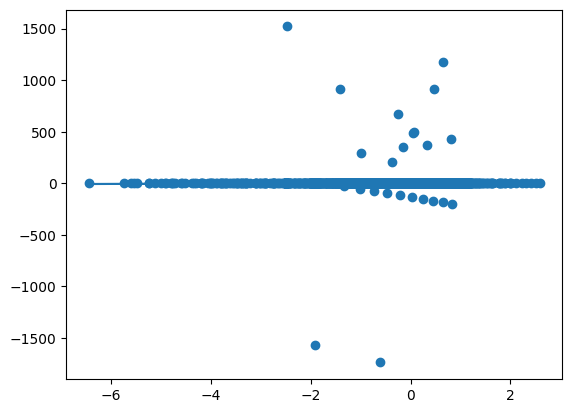

In [ ]:
plt.plot(y_test_fp, y_test_fp)
plt.scatter(y_test_fp, y_test_pred.cpu().detach().numpy())

In [ ]:
test_rmse

57.11692345687909

In [ ]:
def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, title = "Default"):
    model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']).transpose()
    new_header = model_assess_table.iloc[0] #grab the first row for the header
    model_assess_table.columns = new_header #set the header row as the df header
    model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

    train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
    new_header = train_prediction_table.iloc[0] #grab the first row for the header
    train_prediction_table.columns = new_header #set the header row as the df header
    train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

    test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
    new_header = test_prediction_table.iloc[0] #grab the first row for the header
    test_prediction_table.columns = new_header #set the header row as the df header
    test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

    model_train = name_model
    y_train_pred = model_train(X_train)
    y_test_pred  = model_train(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)

    results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2, duration]).transpose()
    results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']


    train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
    train_prediction_result.columns = ['Method','Training Predict','Training Actual']

    test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
    test_prediction_result.columns = ['Method','Test Predict','Test Actual']

    model_assess_table = pd.concat([model_assess_table, results])
    train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
    test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
    return model_assess_table, train_prediction_table, test_prediction_table

In [ ]:
#%% Training Model
'''
def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      model = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
      else:
        X_train_drop = X_train.drop(columns=X_train.shape[1]-1)
        X_test_drop = X_test.drop(columns=X_test.shape[1]-1)
        y_train_pred = model(torch.tensor(X_train_drop.values).to(device)).detach().cpu().numpy()
        y_test_pred  = model(torch.tensor(X_test_drop.values).to(device)).detach().cpu().numpy()

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2']

      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  return model_assess_table, train_prediction_table, test_prediction_table
  '''

## Training Setup & Run

In [ ]:
import time
start_record_time = time.time()

In [ ]:
# Specified model need to run
#names = ["XGB", "RF", "DL1", "DL2"]
#models = [XGB, RF, DL, DL2 ]

names = ["DL"]
models = [model]

# Run Training Model
all_result_model = []
for iteration in range(len(names)) :
    get_model = models[iteration]
    result_model = get_model(x_train_fp, y_train_fp)
    all_result_model.append(result_model)

## Model Evaluation

In [ ]:
# %% Model Evaluation
# Evaluate Model
result_evaluation, train_prediction, test_prediction = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, model, names)

In [ ]:
result_evaluation = result_evaluation.reset_index(drop=True)
train_prediction = train_prediction.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction = test_prediction.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])

# Change datatype
def change_data_type(x):
  return float(x)

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: change_data_type(x))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: change_data_type(x))

In [ ]:
end_record_time = time.time()
duration = end_record_time - start_record_time

from datetime import timedelta
td = timedelta(seconds=duration)
sec = td.seconds
remind_sec = sec % 60
hours = sec // 3600
minutes = (sec // 60) - (hours * 60)
text_time_duration = f"{hours} H : {minutes} M : {remind_sec} S"

In [ ]:
print(text_time_duration)

1 H : 42 M : 38 S


## Inspect

In [ ]:
x_train_fp[2048]
y_train_fp.shape

(15030,)

In [ ]:
all_result_model

[]

In [ ]:
result_evaluation

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate


In [ ]:
test_prediction.shape[0]/4

In [ ]:
train_prediction.shape[0]/4

## Visualization

(-97.79492863303217, 35.62271354873964)

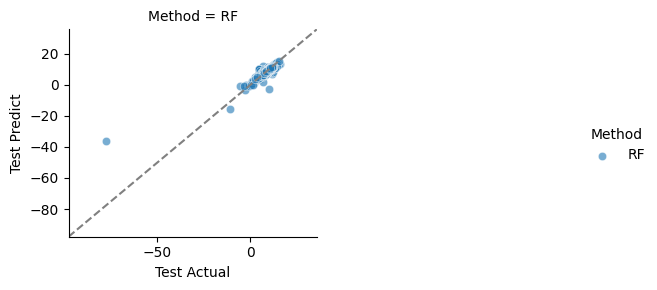

In [ ]:
#%% Visualization
# Specified Range for plot
x_min = min(min(test_prediction["Test Predict"]),min(test_prediction["Test Actual"]))-20
x_max = max(max(test_prediction["Test Predict"]),max(test_prediction["Test Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

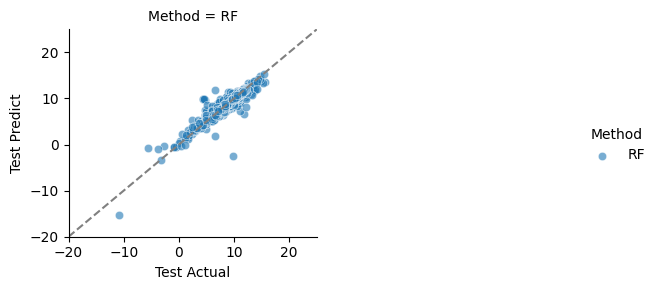

In [ ]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

## Notify User

In [ ]:
# Play Sound from notice User in Google Colab
from google.colab import output
#output.eval_js('new Audio("http://commondatastorage.googleapis.com/codeskulptor-assets/Epoq-Lepidoptera.ogg").play()')

## Send Notification to Line

In [ ]:
import requests
url = 'https://notify-api.line.me/api/notify'
token = '3CfMWfczpal9Zye6bD72a8Ud6FWOODnBHQZHIWM1YU4'
headers = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}

msg = f'run เสร็จแล้ว \n ใช้เวลารันไป {text_time_duration}'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


# Save Result, Model

## Set up for Save

In [ ]:
# Set up
import datetime
#date_run = datetime.now().strftime("%Y-%m-%d")
date_run = "2024-02-12"
# Result Path
result_path1 = f"{date_run} Psat Psat SMILES T VP.csv"
result_path2 = f"{date_run} Psat Psat test_prediction.csv"
result_path3 = f"{date_run} Psat Psat train_prediction.csv"
result_path4 = f"{date_run} Psat Psat result_evaluation.csv"

# Model Path
all_path_export = []
for name in names:
  name_model = name
  model_template1 = f" Psat Psat {name_model}.joblib"
  model_template2 = f" Psat Psat {name_model}.pth"

  path_export = ""
  if("DL" not in name_model):
    path_export = model_template1
  else:
    path_export = model_template2
  path_export = date_run+path_export
  all_path_export.append(path_export)

## Set Up Download to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Result path
com_path = "/content/gdrive/MyDrive/for_ML-Project/For Save/"

com_result_path1 = com_path+ result_path1
com_result_path2 = com_path+ result_path2
com_result_path3 = com_path+ result_path3
com_result_path4 = com_path+ result_path4

## Model path
drive_model_all_path_export = []
for path_save in all_path_export:
  drive_export = com_path+path_save
  drive_model_all_path_export.append(drive_export)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


## Save & Download to Computer

### Save

In [ ]:
# Save Result
df2.to_csv(result_path1)
test_prediction.to_csv(result_path2)
train_prediction.to_csv(result_path3)
result_evaluation.to_csv(result_path4)

In [ ]:
# Save Model
for i in range(len(all_path_export)):
  name = names[i]
  model_export = all_result_model[i]
  path = all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
msg = f'Save เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


### Download to computer

In [ ]:
all_path_export

['2024-01-17 Psat Psat RF.joblib']

In [ ]:
from google.colab import files
# Download Result
files.download(result_path2)
files.download(result_path3)
files.download(result_path4)

# Download Model
for path in all_path_export:
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
msg = f'download ลง คอม เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


## Save to Drive

### Save

In [ ]:
# Save Result to Drive
df2.to_csv(com_result_path1)
test_prediction.to_csv(com_result_path2)
train_prediction.to_csv(com_result_path3)
result_evaluation.to_csv(com_result_path4)

In [ ]:
# Save Model
for i in range(len(drive_model_all_path_export)):
  name = names[i]
  model_export = all_result_model[i]
  path = drive_model_all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
msg = f'download ลง drive เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


# Visualization From File

In [ ]:
# Get result from Model that just got
test_prediction = pd.read_csv("/content/2024-01-03 Psat Psat test_prediction.csv")
train_prediction = pd.read_csv("/content/2024-01-03 Psat Psat train_prediction.csv")
result_evaluation = pd.read_csv("/content/2024-01-03 Psat Psat result_evaluation.csv")

# Get result from Github
#test_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat test_prediction.csv")
#train_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat train_prediction.csv")
#result_evaluation = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat result_evaluation.csv")

In [ ]:
# Change Data that can show Error Metric in each plot
result_evaluation_merge = result_evaluation[["Method","Test RMSE", "Test R2"]]
merged_df = test_prediction.merge(result_evaluation_merge, on='Method', how='inner')  # Inner join
merged_df

,Unnamed: 0,Method,Test Predict,Test Actual,Test RMSE,Test R2
0,0,XGB,10.007981,8.397664,78.518016,-0.060755
1,0,XGB,8.948020,7.725961,78.518016,-0.060755
2,0,XGB,8.671771,1.416442,78.518016,-0.060755
3,0,XGB,8.948020,5.016796,78.518016,-0.060755
4,0,XGB,8.968746,7.362200,78.518016,-0.060755
...,...,...,...,...,...,...
15267,3,DL2,-17.290596,1.133479,75.797770,0.011471
15268,3,DL2,11.440319,8.319116,75.797770,0.011471
15269,3,DL2,9.888784,11.073348,75.797770,0.011471
15270,3,DL2,11.448484,8.341905,75.797770,0.011471


In [ ]:
# Specified Range for plot
x_min = -20; x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(merged_df, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)

# Insert Perfect Line and Error Metric
def plot_with_text2(data, **kws):
    plt.axline((0, 0), slope=1, color='.5', linestyle='--')
    # Access the current subplot and add text
    current_ax = plt.gca()
    current_ax.text(0.5, 0.85, f"RMSE: {data['Test RMSE'].iloc[0]:.3f} \n R2: {data['Test R2'].iloc[0]:.3f} ",
                    transform=current_ax.transAxes, ha='right', va='top')
g.map_dataframe(plot_with_text2)

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# Psat Model from File

In [18]:
#Tunning
class PSAT_DL(nn.Module):
    def __init__(self, N_Input, N_Output, N_Hidden, N_Layer, dropout_rate=0.2):
        super().__init__()
        activation = nn.ReLU
        self.fcs = nn.Sequential(
            nn.Linear(N_Input, N_Hidden),
            activation()
        )
        self.fch = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(N_Hidden, N_Hidden),
                nn.Dropout(p=dropout_rate),
                activation()
            ) for _ in range(N_Layer - 1)]
        )
        self.fce = nn.Linear(N_Hidden, N_Output)

        self.double()

    def forward(self, input):
        x = self.fcs(input)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [19]:
pred_model = PSAT_DL(N_Input = 2049,  N_Output=1, N_Hidden=1000, N_Layer=2, dropout_rate=0.2)
#model = PSAT_DL(N_Input=Size, N_Output=1, N_Hidden=1000, N_Layer=2, dropout_rate=0.3)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
path_model = "/content/SMILE_to_Feature/Second Semester/[Use] Main File/Psat_H1000_L2_D2_500epoch.pth"
#("/content/SMILE_to_Feature/Second Semester/[Use] Main File/Psat_NO_ABCTminTmaxC1-12.csv")
#pred_model.load_state_dict(torch.load("Psat_H1000_L3_D2_noearly.pth", map_location = torch.device('cpu')))
pred_model.load_state_dict(torch.load(path_model, map_location = torch.device('cpu')))

<All keys matched successfully>

In [20]:
#inputs_test
pred0 = pred_model(inputs)
inv_pred0 = scale_y.inverse_transform(pred0.detach().numpy())

pred1 = pred_model(inputs_test)
inv_pred1 = scale_y.inverse_transform(pred1.detach().numpy())

In [21]:
scale_y.inverse_transform(y_test_fp.reshape(-1,1))

array([[ 7.58157436],
       [ 9.13194381],
       [10.36891189],
       ...,
       [ 4.46675854],
       [ 5.15481347],
       [ 5.77396341]])

In [22]:
df_com0 = pd.DataFrame({
    "ln_Psat_act" : scale_y.inverse_transform(y_train_fp.reshape(-1,1)).flatten(),
    "ln_Psat_pred": inv_pred0.flatten(),
})
#df_com0[df_com0["Psat_act"]>15]

In [24]:
df_com0["Psat_act (atm)"] = np.exp(df_com0["ln_Psat_act"])/10**5
df_com0["Psat_pred (atm)"] = np.exp(df_com0["ln_Psat_pred"])/10**5

In [23]:
df_com0

,ln_Psat_act,ln_Psat_pred
0,6.428063,6.536538
1,8.058521,8.027392
2,9.409872,9.182646
3,10.548132,10.056838
4,11.520021,10.866235
...,...,...
8415,1.632097,1.391930
8416,3.320535,3.025816
8417,4.783169,4.534630
8418,6.062459,5.566744


In [25]:
df_com1 = pd.DataFrame({
    "ln_Psat_act" : scale_y.inverse_transform(y_test_fp.reshape(-1,1)).flatten(),
    "ln_Psat_pred": inv_pred1.flatten(),
})
#df_com1[df_com1["Psat_act"]>15]
#result1 = pd.concat([df_com1, df_T], axis=1, join="inner")

In [26]:
df_com1["Psat_act (atm)"] = np.exp(df_com1["ln_Psat_act"])/10**5
df_com1["Psat_pred (atm)"] = np.exp(df_com1["ln_Psat_pred"])/10**5

In [27]:
df_com1

,ln_Psat_act,ln_Psat_pred,Psat_act (atm),Psat_pred (atm)
0,7.581574,7.604491,0.019617,0.020072
1,9.131944,8.886192,0.092460,0.072314
2,10.368912,10.230814,0.318538,0.277451
3,11.378785,11.254502,0.874467,0.772268
4,12.218843,11.829743,2.025704,1.372752
...,...,...,...,...
2130,2.832162,6.071465,0.000170,0.004333
2131,3.697618,6.486830,0.000404,0.006564
2132,4.466759,7.021310,0.000871,0.011203
2133,5.154813,7.541486,0.001733,0.018846


## Train

(-5.527856419558724, 19.09907452847629)

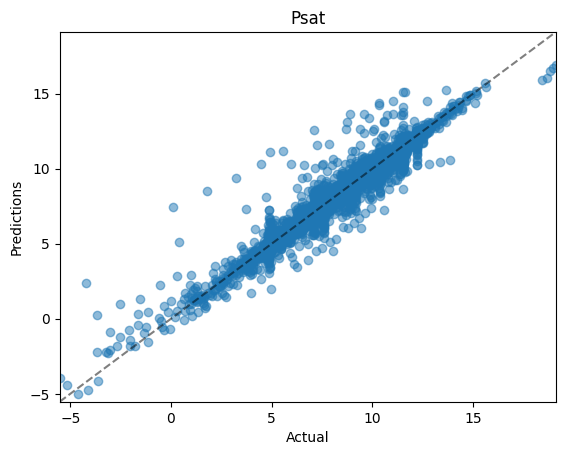

In [28]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = min(min(df_com0["ln_Psat_act"]),min(df_com0["ln_Psat_pred"]))
x_max = max(max(df_com0["ln_Psat_act"]),max(df_com0["ln_Psat_pred"]))
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

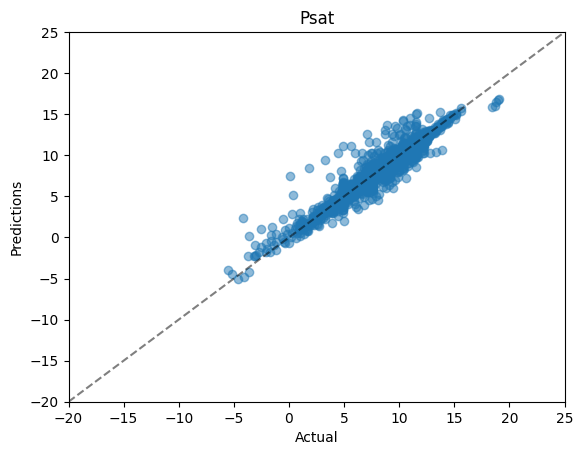

In [29]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = -20
x_max = 25
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

Text(0.5, 1.0, 'Psat')

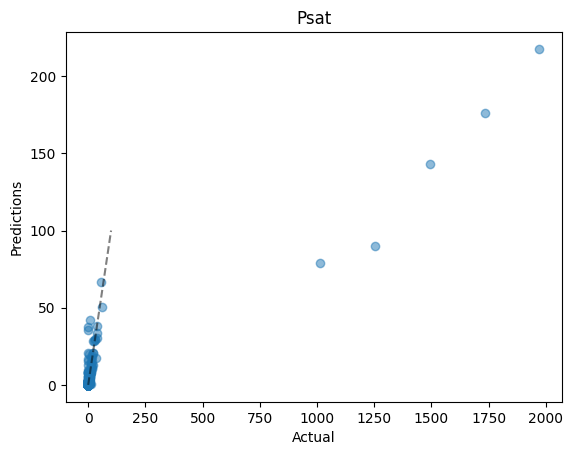

In [30]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = 0
x_max = 100
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com0["Psat_act (atm)"], df_com0["Psat_pred (atm)"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)

## Test

In [90]:
print(len(df_com1))
df_com1["%diff_ln"] = abs(df_com1["ln_Psat_act"]-df_com1["ln_Psat_pred"])/df_com1["ln_Psat_act"]*100
df_com1["ln_Pass?"] = np.where(df_com1["%diff_ln"] <= 30, "PASS", "NOT")

df_com1["%diff"] = abs(df_com1["Psat_act (atm)"]-df_com1["Psat_pred (atm)"])/df_com1["Psat_act (atm)"]*100
df_com1["VP_Pass?"] = np.where(df_com1["%diff"] <= 100, "PASS", "NOT")

2135


In [91]:
df_com1[df_com1["ln_Pass?"]=="NOT"]

,ln_Psat_act,ln_Psat_pred,Psat_act (atm),Psat_pred (atm),%diff,Pass?,%diff_ln,ln_Pass?,VP_Pass?
65,3.212106,6.291666,0.000248,0.005401,2074.882758,NOT,95.873538,NOT,NOT
66,3.994116,7.191164,0.000543,0.013276,2346.020981,NOT,80.043933,NOT,NOT
67,4.719253,7.698922,0.001121,0.022060,1868.130919,NOT,63.138584,NOT,NOT
68,5.393503,8.312066,0.002200,0.040727,1751.466183,NOT,54.112571,NOT,NOT
69,6.022041,8.817179,0.004124,0.067492,1536.490176,NOT,46.415146,NOT,NOT
80,4.893051,3.329344,0.001334,0.000279,79.064153,NOT,31.957713,NOT,PASS
150,4.135946,8.307461,0.000625,0.040540,6381.362720,NOT,100.860030,NOT,NOT
151,6.814869,9.662880,0.009113,0.157230,1625.344322,NOT,41.791146,NOT,NOT
190,0.619351,-0.778932,0.000019,0.000005,75.297934,NOT,225.765953,NOT,PASS
195,4.371930,5.790998,0.000792,0.003273,313.326434,NOT,32.458605,NOT,NOT


(-3.387744830204044, 16.25786360258667)

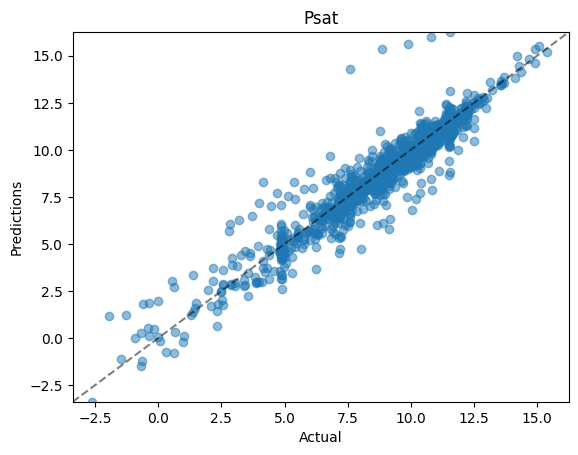

In [92]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = min(min(df_com1["ln_Psat_act"]),min(df_com1["ln_Psat_pred"]))
x_max = max(max(df_com1["ln_Psat_act"]),max(df_com1["ln_Psat_pred"]))
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

Text(0, 0.5, 'Predict ln($P_{sat}$) [Pa]')

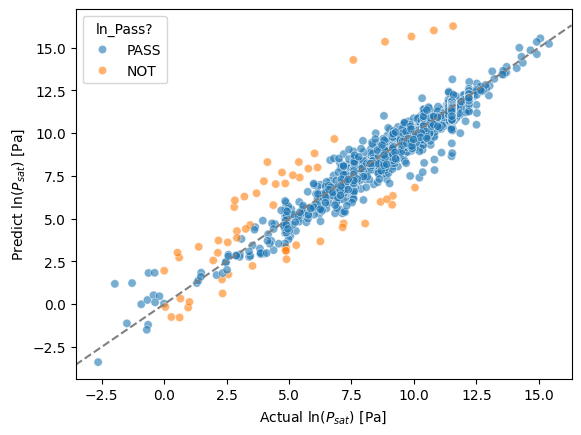

In [93]:
# Plot each method

#plt.plot(x = final3["Test Predict"], y = final3["Test Predict"])
markers = {"PASS": "o", "NOT": "X"}
gc = sns.scatterplot(df_com1, x="ln_Psat_act", y="ln_Psat_pred", hue="ln_Pass?"
#, style= "RMSE2"
, alpha=0.6, markers=markers)
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

# Add Legend, range of show
#plt.title(best_name)
plt.xlabel("Actual ln($P_{sat}$) [Pa]")
plt.ylabel("Predict ln($P_{sat}$) [Pa]")
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)

#gc.xlabels("Actual log($P_{sat}$) [Pa]")
#plt.ylabel("Predict log($P_{sat}$) [Pa]")
#gc.set_xlabels("Actual log($P_{sat}$) [Pa]")
#gc.set_ylabels("Predict log($P_{sat}$) [Pa]")

Text(0, 0.5, '$P_{sat}$) [atm]')

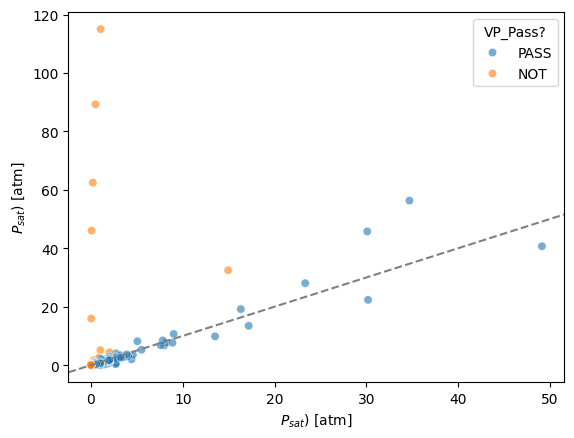

In [88]:
# Plot each method

#plt.plot(x = final3["Test Predict"], y = final3["Test Predict"])
markers = {"PASS": "o", "NOT": "X"}
gc = sns.scatterplot(df_com1, x="Psat_act (atm)", y="Psat_pred (atm)", hue="VP_Pass?"
#, style= "RMSE2"
, alpha=0.6, markers=markers)
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

# Add Legend, range of show
#plt.title(best_name)
plt.xlabel("$P_{sat}$) [atm]")
plt.ylabel("$P_{sat}$) [atm]")
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)

#gc.xlabels("Actual log($P_{sat}$) [Pa]")
#plt.ylabel("Predict log($P_{sat}$) [Pa]")
#gc.set_xlabels("Actual log($P_{sat}$) [Pa]")
#gc.set_ylabels("Predict log($P_{sat}$) [Pa]")

(-20.0, 25.0)

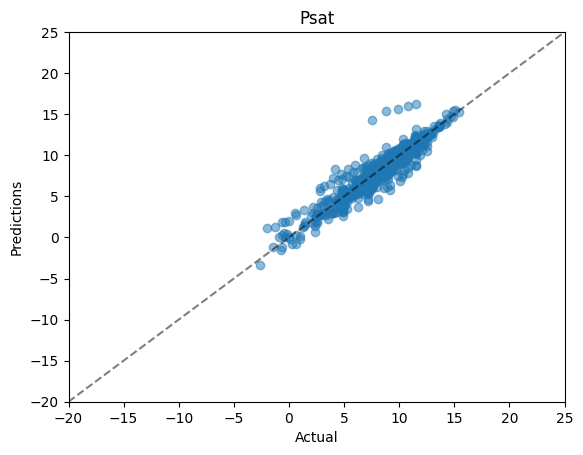

In [89]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = -20
x_max = 25
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

Text(0.5, 1.0, 'Psat')

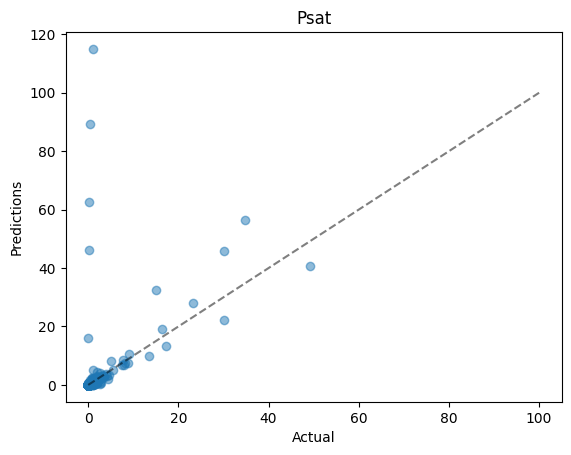

In [33]:
#%% Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x_min = 0
x_max = 100
y_min, y_max = x_min, x_max

x = np.linspace(x_min, x_max, 100)
y = x

# PyPlot
plt.plot([x_min, x_max], [y_min, y_max], color="black", alpha=0.5, linestyle="--")
plt.scatter(df_com1["Psat_act (atm)"], df_com1["Psat_pred (atm)"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predictions")
plt.title("Psat")
#plt.xlim(x_min, x_max)
#plt.ylim(y_min, y_max)

In [39]:
#Training-ln
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"])
rmse = np.sqrt(mean_squared_error(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"]))
mape = mean_absolute_percentage_error(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"])
r2 = r2_score(df_com0["ln_Psat_act"], df_com0["ln_Psat_pred"])
mae,rmse, mape, r2

(0.2548754003154736,
 0.4978332162590772,
 0.10441662306895641,
 0.9541402568573574)

In [40]:
#Test-ln
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"])
rmse = np.sqrt(mean_squared_error(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"]))
mape = mean_absolute_percentage_error(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"])
r2 = r2_score(df_com1["ln_Psat_act"], df_com1["ln_Psat_pred"])
mae,rmse, mape, r2

(0.3775700967654902,
 0.6585119047167197,
 0.31448309052959195,
 0.9257130727000367)

In [36]:
#Training-VP
from sklearn.metrics import mean_squared_error, r2_score
mae = mean_absolute_error(df_com0["Psat_act (atm)"], df_com0["Psat_pred (atm)"])
rmse = np.sqrt(mean_squared_error(df_com0["Psat_act (atm)"], df_com0["Psat_pred (atm)"]))
mape = mean_absolute_percentage_error(df_com0["Psat_act (atm)"], df_com0["Psat_pred (atm)"])
r2 = r2_score(df_com0["Psat_act (atm)"], df_com0["Psat_pred (atm)"])
mae,rmse, mape, r2

(0.9385625392670568,
 33.712377553552095,
 0.9710051659562585,
 0.1847981438577343)

In [37]:
#Test-VP
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(df_com1["Psat_act (atm)"], df_com1["Psat_pred (atm)"])
rmse = np.sqrt(mean_squared_error(df_com1["Psat_act (atm)"], df_com1["Psat_pred (atm)"]))
mape = mean_absolute_percentage_error(df_com1["Psat_act (atm)"], df_com1["Psat_pred (atm)"])
r2 = r2_score(df_com1["Psat_act (atm)"], df_com1["Psat_pred (atm)"])
mae,rmse, mape, r2

(0.3088309663599328,
 3.6509313555570393,
 1.4578617887804732,
 -2.6455073720970623)

# ABC From File

In [ ]:
# Get result from Github
ML_model = load("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-03 Psat Psat RF.joblib")
all_result_model = [ML_model]
names = ["RF"]

In [ ]:
#%% Training Model

def model_assess2(X_all, y_all, list_model, name_model, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','MAE', 'RMSE','R2']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  prediction_table = pd.DataFrame(['Method','Predict','Actual']).transpose()
  new_header = prediction_table.iloc[0] #grab the first row for the header
  prediction_table.columns = new_header #set the header row as the df header
  prediction_table.drop(index=prediction_table.index[0], axis=0, inplace=True)

  for iteration in range(len(list_model)):
      model = list_model[iteration]
      name = name_model[iteration]
      if("DL" not in name):
        model.fit(X_all, y_all)
        y_pred = model.predict(X_all)
      else:
        X_drop = X_all.drop(columns=X_all.shape[1]-1)
        y_pred = model(torch.tensor(X_drop.values)).detach().numpy()

      mae = mean_absolute_error(y_all, y_pred)
      rmse = mean_squared_error(y_all, y_pred, squared=False)
      r2 = r2_score(y_all, y_pred)

      results = pd.DataFrame([name_model[iteration],mae, rmse, r2]).transpose()
      results.columns = ['Method','MAE', 'RMSE','R2']

      prediction_result = pd.DataFrame([name_model[iteration],y_pred, y_all]).transpose()
      prediction_result.columns = ['Method','Predict','Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      prediction_table = pd.concat([prediction_table, prediction_result])
  return model_assess_table, prediction_table

In [ ]:
result_evaluation, prediction = model_assess2(x_data_fp, y_data_fp, all_result_model, names)
result_evaluation = result_evaluation.reset_index(drop=True)
prediction = prediction.reset_index(drop=True).explode(['Predict', 'Actual'])


# Change datatype
def change_data_type(x):
  return float(x)

prediction['Predict'] = prediction['Predict'].apply(lambda x: change_data_type(x))
prediction = prediction.reset_index()

In [ ]:
temp = prediction[["Predict"]].reset_index(drop=True)
df3 = df2.copy()
df3 = pd.concat([df3, temp], axis = 1)
df4 = df3.copy()
df4 = df3.groupby('SMILES', sort=False, dropna=False)['T'].apply(list)
df4

SMILES
C=O                          [190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...
CCOC(=O)N                    [338.0, 351.22222900390625, 364.4444580078125,...
CN1CCC[C@H]1C2=CN=CC=C2      [334.0, 354.77777099609375, 375.5555419921875,...
C(C(CO)O)O                   [341.0, 365.6666564941406, 390.3333435058594, ...
CN(C)N                       [238.0, 244.11111450195312, 250.22222900390625...
                                                   ...                        
CC(C)OCC(C)OCC(C)OCC(C)O     [355.0, 374.3333435058594, 393.6666564941406, ...
CCCO[Ge](OCCC)(OCCC)OCCC     [343.0, 355.22222900390625, 367.4444580078125,...
CC(C(=O)OC(C)C(=O)OC)O       [317.0, 324.4444580078125, 331.8888854980469, ...
CCCCOC(=O)C(C)OC(=O)C        [331.0, 348.1111145019531, 365.22222900390625,...
CCCCOC(=O)C(C)OC(=O)C(C)O    [324.0, 333.22222900390625, 342.4444580078125,...
Name: T, Length: 1899, dtype: object

In [ ]:
result = df3.groupby('SMILES', sort=False)[['T', 'Vapor_Presssure', 'Predict']].agg(list)
# Reset the index to create a DataFrame
result = result.reset_index()
result

,SMILES,T,Vapor_Presssure,Predict
0,C=O,"[190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...","[7.581574364482325, 8.316537118226234, 8.97711...","[8.08563462739309, 8.49993187840082, 8.9514968..."
1,CCOC(=O)N,"[338.0, 351.22222900390625, 364.4444580078125,...","[6.428062761494029, 7.192461455697213, 7.89259...","[6.640493598558538, 7.319272393386114, 8.00254..."
2,CN1CCC[C@H]1C2=CN=CC=C2,"[334.0, 354.77777099609375, 375.5555419921875,...","[4.848526499977353, 5.986162236744422, 6.98182...","[5.133536107619277, 6.207200197926775, 7.42523..."
3,C(C(CO)O)O,"[341.0, 365.6666564941406, 390.3333435058594, ...","[0.6415754658113535, 2.694676143579546, 4.4201...","[2.034855515702384, 3.6366866795282657, 5.1631..."
4,CN(C)N,"[238.0, 244.11111450195312, 250.22222900390625...","[6.166674419597758, 6.653305107846041, 7.11157...","[6.5096126852342175, 6.623706343938554, 7.0321..."
...,...,...,...,...
1894,CC(C)OCC(C)OCC(C)OCC(C)O,"[355.0, 374.3333435058594, 393.6666564941406, ...","[4.881800031308973, 5.92654046864067, 6.866759...","[5.140893384594914, 6.096777891998492, 6.96473..."
1895,CCCO[Ge](OCCC)(OCCC)OCCC,"[343.0, 355.22222900390625, 367.4444580078125,...","[4.445406432309333, 5.2158210969216725, 5.9264...","[4.794788527120863, 5.323107795268345, 6.11472..."
1896,CC(C(=O)OC(C)C(=O)OC)O,"[317.0, 324.4444580078125, 331.8888854980469, ...","[2.5812522706303724, 3.223757326560456, 3.8266...","[3.013679000518691, 3.435888068820115, 4.09231..."
1897,CCCCOC(=O)C(C)OC(=O)C,"[331.0, 348.1111145019531, 365.22222900390625,...","[4.928566362502519, 6.128070798648743, 7.14648...","[5.04730002802046, 6.305584380659897, 7.179396..."


In [ ]:
x = result["T"].apply(lambda num: [1/num1 for num1 in num])
y = result["Predict"]

xy_table = pd.DataFrame({
    "x" : x,
    "y" : y})

result2 = result.join(xy_table)
#%%
from scipy.optimize import curve_fit
def objective(X, a, b, c):
    x,y = X
    # Linearized Equation : y + C * y * x1 = A + B * x1
    # return a +(b*x) - (c*y*x)

    # Linearized Equation : logP = A + (AC-B) (1/T) +  (-C) (logP /T)
    a0 = a
    a1 = a*c - b
    a2 = -c
    x1 = x
    x2 = y*x
    return a0 + a1*x1 + a2*x2

def getABC(row):
    #print(row.x)
    x1 = row.x
    y1 = row.y
    popt, _ = curve_fit(objective, (x1,y1), y1)
    a,b,c = popt
    return [a,b,c]
#z = func((x,y), a, b, c) * 1
result2["ABC"] = result2.apply(getABC, axis=1)
result2[['A_Pred', 'B_Pred', 'C_Pred']] = pd.DataFrame(result2['ABC'].tolist())


x_test = result["T"].apply(lambda num: [1/num1 for num1 in num])
y_test = result["Vapor_Presssure"]
xy_test_table = pd.DataFrame({
    "x_test" : x_test,
    "y_test" : y_test})
result2 = result2.join(xy_test_table)
def getABC2(row):
    #print(row.x)
    x1 = row.x_test
    y1 = row.y_test
    popt, _ = curve_fit(objective, (x1,y1), y1, method="dogbox")
    a,b,c = popt
    return [a,b,c]
result2["ABC_test"] = result2.apply(getABC2, axis=1)
result2[['A_test', 'B_test', 'C_test']] = pd.DataFrame(result2['ABC_test'].tolist())
result2.head(3)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,SMILES,T,Vapor_Presssure,Predict,x,y,ABC,A_Pred,B_Pred,C_Pred,x_test,y_test,ABC_test,A_test,B_test,C_test
0,C=O,"[190.0, 199.0, 208.0, 217.0, 226.0, 235.0, 244...","[7.581574364482325, 8.316537118226234, 8.97711...","[8.08563462739309, 8.49993187840082, 8.9514968...","[0.005263157894736842, 0.005025125628140704, 0...","[8.08563462739309, 8.49993187840082, 8.9514968...","[17.642868405615147, 1182.8598673800616, -69.4...",17.642868,1182.859867,-69.463837,"[0.005263157894736842, 0.005025125628140704, 0...","[7.581574364482325, 8.316537118226234, 8.97711...","[21.370292249338135, 2204.1265538212515, -30.1...",21.370292,2204.126554,-30.150
1,CCOC(=O)N,"[338.0, 351.22222900390625, 364.4444580078125,...","[6.428062761494029, 7.192461455697213, 7.89259...","[6.640493598558538, 7.319272393386114, 8.00254...","[0.0029585798816568047, 0.0028472001981084123,...","[6.640493598558538, 7.319272393386114, 8.00254...","[21.450280435207972, 3761.3436627822102, -84.5...",21.450280,3761.343663,-84.500079,"[0.0029585798816568047, 0.0028472001981084123,...","[6.428062761494029, 7.192461455697213, 7.89259...","[23.84683764449035, 5018.000670035375, -49.919...",23.846838,5018.000670,-49.920
2,CN1CCC[C@H]1C2=CN=CC=C2,"[334.0, 354.77777099609375, 375.5555419921875,...","[4.848526499977353, 5.986162236744422, 6.98182...","[5.133536107619277, 6.207200197926775, 7.42523...","[0.0029940119760479044, 0.002818665885386067, ...","[5.133536107619277, 6.207200197926775, 7.42523...","[19.238281010142614, 3013.015645100715, -121.7...",19.238281,3013.015645,-121.737979,"[0.0029940119760479044, 0.002818665885386067, ...","[4.848526499977353, 5.986162236744422, 6.98182...","[21.942530703904826, 4981.654364988623, -42.57...",21.942531,4981.654365,-42.573


In [ ]:
result3 = result2[["SMILES", "A_Pred", "B_Pred", "C_Pred", "A_test", "B_test", "C_test"]]
df_for_lookup = df[["SMILES","A", 'B', "C"]]
final = pd.concat([result3, df_for_lookup[["A", "B", "C"]]], axis=1)
print(final.describe())
final

            A_Pred        B_Pred       C_Pred       A_test       B_test  \
count  1899.000000   1899.000000  1899.000000  1899.000000  1899.000000   
mean     16.785065   2110.406758  -144.310412    20.087967  3296.074107   
std       6.217676   2168.883106   137.210419     4.108141  1858.104718   
min     -23.041112 -16383.000000  -681.667399     9.537105     0.964268   
25%      13.141839    395.764163  -199.730589    20.541408  2723.405440   
50%      18.857844   2255.244199  -107.202545    20.916107  3358.780875   
75%      20.722021   3260.900323   -58.006761    22.349513  4415.432568   
max      34.507058  15254.949337   257.000000    27.048467  7102.717471   

             C_test            A            B            C  
count  1.899000e+03  1899.000000  1899.000000  1899.000000  
mean  -4.639798e+01    21.565060  3838.133069   -59.844509  
std    3.763382e+01     1.583863  1168.597268    32.692252  
min   -1.475500e+02    16.219064   911.234235  -147.550000  
25%   -6.877000e+01

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C
0,C=O,17.642868,1182.859867,-69.463837,21.370292,2204.126554,-30.150000,21.370292,2204.126554,-30.150
1,CCOC(=O)N,21.450280,3761.343663,-84.500079,23.846838,5018.000670,-49.920000,23.846838,5018.000667,-49.920
2,CN1CCC[C@H]1C2=CN=CC=C2,19.238281,3013.015645,-121.737979,21.942531,4981.654365,-42.573000,21.942531,4981.654362,-42.573
3,C(C(CO)O)O,22.780799,5552.565710,-74.235884,24.322575,6153.389234,-81.155001,24.322575,6153.389259,-81.155
4,CN(C)N,9.462657,23.056457,-237.851005,22.379838,3202.002456,-40.506000,22.379838,3202.002461,-40.506
...,...,...,...,...,...,...,...,...,...,...
1894,CC(C)OCC(C)OCC(C)OCC(C)O,20.272266,3678.429670,-113.938803,24.722672,6901.250470,-7.170000,24.722672,6901.250476,-7.170
1895,CCCO[Ge](OCCC)(OCCC)OCCC,22.854579,5189.286953,-57.809433,23.539143,5550.358348,-52.310000,23.539143,5550.358341,-52.310
1896,CC(C(=O)OC(C)C(=O)OC)O,14.733064,1448.504308,-195.155641,22.802385,4587.163997,-90.149999,22.802385,4587.163971,-90.150
1897,CCCCOC(=O)C(C)OC(=O)C,18.162353,2173.813661,-165.678623,19.619269,2827.284491,-138.545995,19.619268,2827.284368,-138.546


In [ ]:
temp = result.iloc[0]
#print(temp)
temp_df = pd.DataFrame({
    "T":temp["T"]
    ,"Acutal Psat": temp["Vapor_Presssure"]
    ,"Predict Psat": temp["Predict"]
})
print(temp_df.describe())
temp_df.head()

                T  Acutal Psat  Predict Psat
count   10.000000    10.000000     10.000000
mean   230.500000    10.180152     10.099330
std     27.248853     1.552375      1.314651
min    190.000000     7.581574      8.085635
25%    210.250000     9.126351      9.084432
50%    230.500000    10.363359     10.196425
75%    250.750000    11.375601     11.202697
max    271.000000    12.218843     11.754274


,T,Acutal Psat,Predict Psat
0,190.0,7.581574,8.085635
1,199.0,8.316537,8.499932
2,208.0,8.977115,8.951497
3,217.0,9.574057,9.483237
4,226.0,10.116136,9.945203


(2.581574364482325, 17.21884299112518)

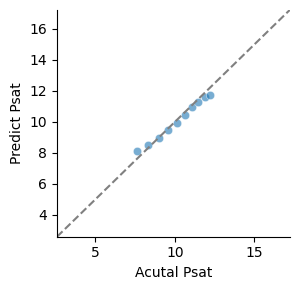

In [ ]:
#%% Visualization
# Specified Range for plot
x_min = min(min(temp_df["Predict Psat"]),min(temp_df["Acutal Psat"]))-5
x_max = max(max(temp_df["Predict Psat"]),max(temp_df["Acutal Psat"]))+5
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(temp_df)
g.map_dataframe(sns.scatterplot, x="Acutal Psat", y="Predict Psat", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [ ]:
temp_df

,T,Acutal Psat,Predict Psat
0,190.0,7.581574,8.085635
1,199.0,8.316537,8.499932
2,208.0,8.977115,8.951497
3,217.0,9.574057,9.483237
4,226.0,10.116136,9.945203
5,235.0,10.610582,10.447647
6,244.0,11.063411,10.942907
7,253.0,11.479664,11.289293
8,262.0,11.863600,11.593675
9,271.0,12.218843,11.754274
